In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Current Working Directory: /content/drive/MyDrive/Colab Notebooks


In [2]:
#import the packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, precision_recall_curve, auc
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score


In [ ]:
#learning curve function
def plot_learning_curve(model, X, y, scoring, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring=scoring, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

In [3]:
#set random seed
np.random.seed(42)

In [3]:
#import the data

X_train_resampled = pd.read_csv('X_train_transformed_smote.csv')
X_valid_transformed = pd.read_csv('X_valid_transformed_basicfull.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')

y_train_resampled = pd.read_csv('y_train_smote.csv')
y_valid = pd.read_csv('y_valid_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')
y_train_resampled = np.ravel(y_train_resampled.values)
y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:

dt_classifier = DecisionTreeClassifier(random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT SMOTE:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_resampled, y_train_resampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)

#save
joblib.dump(best_dt_classifier, 'dt_smote_v2.pkl')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  15.8s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  13.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  13.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=  21.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=  20.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=  21.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  14.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

['dt_smote_v2.pkl']

In [ ]:
#best_dt_classifier = joblib.load('dt_smote.pkl')

In [ ]:
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [ ]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9786


In [ ]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5365


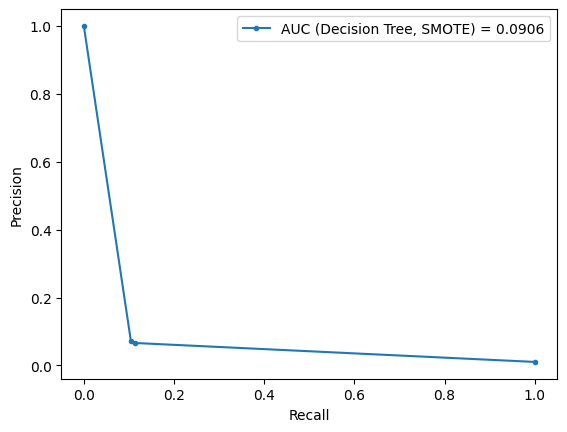

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, SMOTE) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")

Class 0: F1 Score = 0.99
Class 1: F1 Score = 0.08
Class accuracy: F1 Score = 0.98
Class macro: F1 Score = 0.54
Class weighted: F1 Score = 0.98


In [ ]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[156057   2267]
 [  1501    175]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158324
           1       0.07      0.10      0.08      1676

    accuracy                           0.98    160000
   macro avg       0.53      0.55      0.54    160000
weighted avg       0.98      0.98      0.98    160000



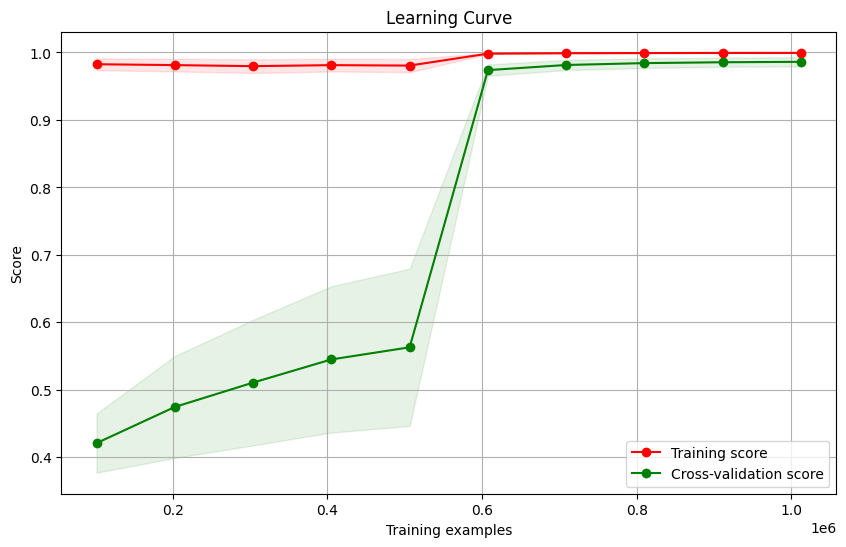

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_resampled, y_train_resampled, scoring, train_sizes)

In [ ]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))


Confusion Matrix:
[[156057   2267]
 [  1501    175]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158324
           1       0.07      0.10      0.08      1676

    accuracy                           0.98    160000
   macro avg       0.53      0.55      0.54    160000
weighted avg       0.98      0.98      0.98    160000



In [ ]:
##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)


Chosen threshold: 1.0
False Positive Rate: 0.014318738788812815
Recall: 0.10441527446300716
[[156057   2267]
 [  1501    175]]


In [4]:
##DT with adasyn
X_train_resampled = pd.read_csv('X_train_transformed_adasyn.csv')

y_train_resampled = pd.read_csv('y_train_adasyn.csv')

y_train_resampled = np.ravel(y_train_resampled.values)

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:

dt_classifier = DecisionTreeClassifier(random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT SMOTE:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_resampled, y_train_resampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)

#save
joblib.dump(best_dt_classifier, 'dt_adasyn_v2.pkl')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  12.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  11.7s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  10.8s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   8.9s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=  11.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=  10.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  10.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-9a7185c312cd>", line 36, in <cell line: 36>
    joblib.dump(best_dt_classifier, 'dt_adasyn_v2.pkl')
  File "/usr/local/lib/python3.10/dist-packages/joblib/numpy_pickle.py", line 552, in dump
    with open(filename, 'wb') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'dt_adasyn_v2.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-package

In [5]:
##{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}

hyperparameters = {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}
dt_classifier = DecisionTreeClassifier(**hyperparameters, random_state=42)

# Fit the model
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the classifier on the test set
# Replace X_valid_transformed with your actual test data
y_pred = dt_classifier.predict(X_valid_transformed)

# Save the model
joblib.dump(dt_classifier, 'dt_adasyn_v2.pkl')

['dt_adasyn_v2.pkl']

In [ ]:
best_dt_classifier = joblib.load('dt_adasyn.pkl')
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [6]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9773


In [7]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5438


In [8]:
best_dt_classifier = joblib.load('dt_adasyn_v2.pkl')

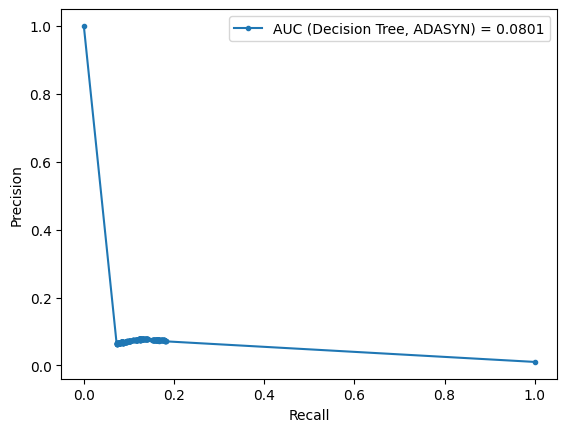

In [9]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, ADASYN) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


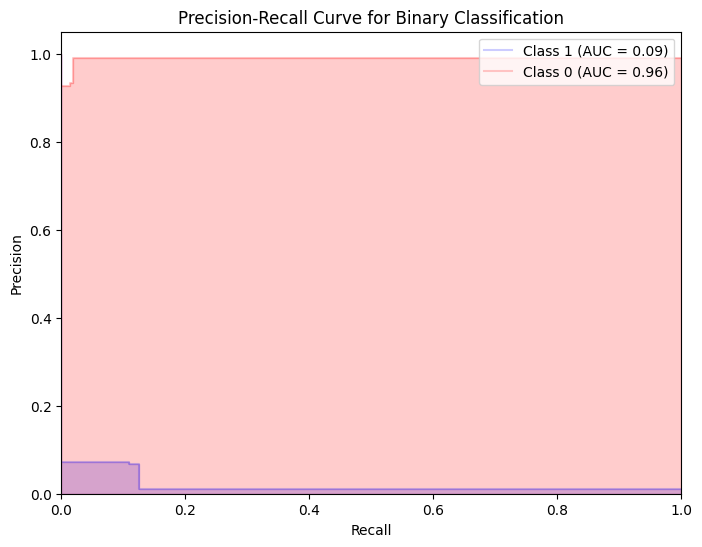

AUC Class 1: 0.0937
AUC Class 0: 0.9610


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming y_valid is the true labels and X_valid_transformed is the transformed validation data

# Calculate precision-recall curve for class 1
precision_class1, recall_class1, _ = precision_recall_curve(y_valid, best_dt_classifier.predict_proba(X_valid_transformed)[:, 1])
auc_score_class1 = auc(recall_class1, precision_class1)

# Calculate precision-recall curve for class 0
precision_class0, recall_class0, _ = precision_recall_curve(1 - y_valid, 1 - best_dt_classifier.predict_proba(X_valid_transformed)[:, 0])  # Invert labels for class 0
auc_score_class0 = auc(recall_class0, precision_class0)

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))

# Plot precision-recall curve for class 1
plt.step(recall_class1, precision_class1, color='b', alpha=0.2, where='post', label=f'Class 1 (AUC = {auc_score_class1:.2f})')
plt.fill_between(recall_class1, precision_class1, step='post', alpha=0.2, color='b')

# Plot precision-recall curve for class 0
plt.step(recall_class0, precision_class0, color='r', alpha=0.2, where='post', label=f'Class 0 (AUC = {auc_score_class0:.2f})')
plt.fill_between(recall_class0, precision_class0, step='post', alpha=0.2, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Binary Classification')
plt.legend(loc='upper right')
plt.show()

print(f"AUC Class 1: {auc_score_class1:.4f}")
print(f"AUC Class 0: {auc_score_class0:.4f}")

In [ ]:


average_precision = average_precision_score(y_valid, y_pred)

print(f'Area Under the Precision-Recall Curve (AUC-PR): {average_precision:.4f}')

Area Under the Precision-Recall Curve (AUC-PR): 0.0173


In [10]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")

Class 0: F1 Score = 0.99
Class 1: F1 Score = 0.10
Class accuracy: F1 Score = 0.97
Class macro: F1 Score = 0.54
Class weighted: F1 Score = 0.98


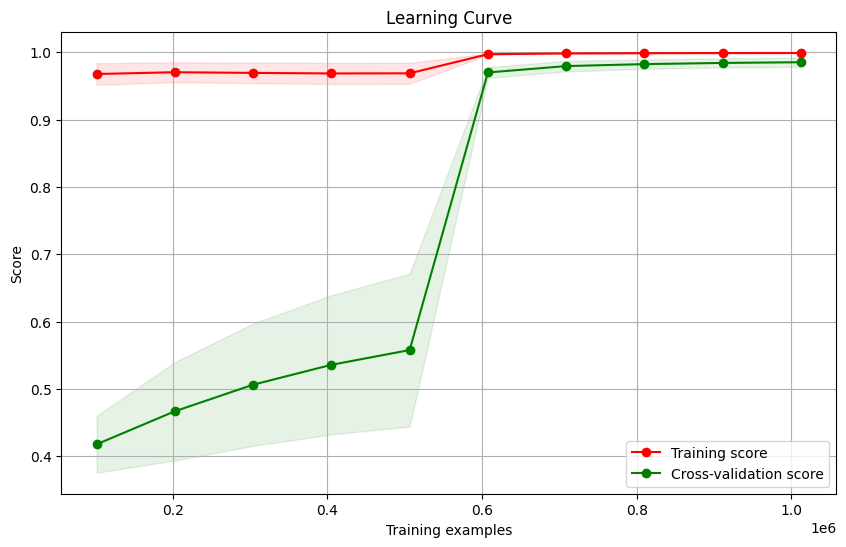

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_resampled, y_train_resampled, scoring, train_sizes)

In [11]:
##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")

print(conf_matrix)

Chosen threshold: 1.0
False Positive Rate: 0.011305929612692958
[[156534   1790]
 [  1554    122]]


In [12]:
###DT with random undersampling

X_train_undersampled = pd.read_csv('X_train_random_undersampl.csv')

y_train_undersampled = pd.read_csv('y_train_random_undersampl.csv')

y_train_undersampled = np.ravel(y_train_undersampled.values)

In [13]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [15]:
dt_classifier = DecisionTreeClassifier(random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_undersampled, y_train_undersampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT eandom undersampling:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_undersampled, y_train_undersampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)


#save model to a file
joblib.dump(best_dt_classifier, 'dt_random_undersampling_v2.pkl')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

['dt_random_undersampling_v2.pkl']

In [ ]:
best_dt_classifier = joblib.load('dt_random_undersampling.pkl')
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [16]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4479


In [17]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8370


In [18]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[116301  42023]
 [   542   1134]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85    158324
           1       0.03      0.68      0.05      1676

    accuracy                           0.73    160000
   macro avg       0.51      0.71      0.45    160000
weighted avg       0.99      0.73      0.84    160000



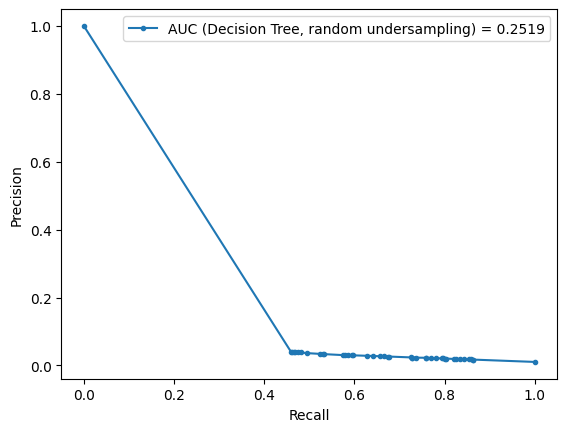

In [19]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, random undersampling) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
average_precision = average_precision_score(y_valid, y_pred)
print(f'Area Under the Precision-Recall Curve (AUC-PR): {average_precision:.4f}')

Area Under the Precision-Recall Curve (AUC-PR): 0.0255


In [20]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")


Class 0: F1 Score = 0.85
Class 1: F1 Score = 0.05
Class accuracy: F1 Score = 0.73
Class macro: F1 Score = 0.45
Class weighted: F1 Score = 0.84


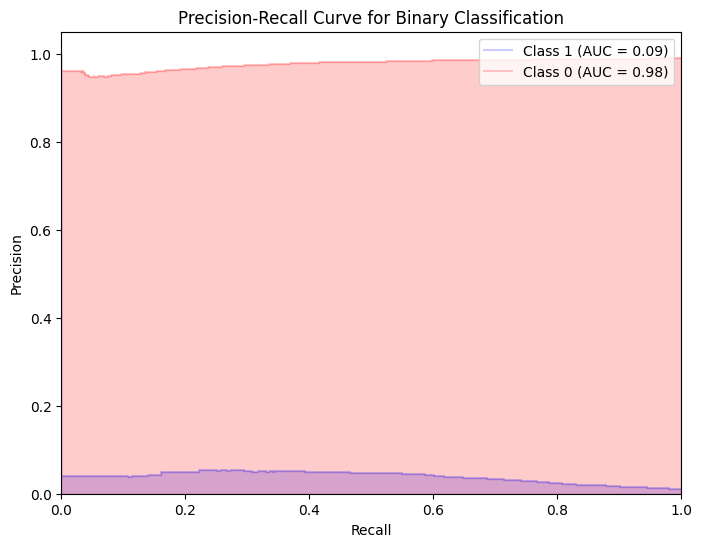

AUC Class 1: 0.0895
AUC Class 0: 0.9775


In [ ]:
# Calculate precision-recall curve for class 1
precision_class1, recall_class1, _ = precision_recall_curve(y_valid, best_dt_classifier.predict_proba(X_valid_transformed)[:, 1])
auc_score_class1 = auc(recall_class1, precision_class1)

# Calculate precision-recall curve for class 0
precision_class0, recall_class0, _ = precision_recall_curve(1 - y_valid, 1 - best_dt_classifier.predict_proba(X_valid_transformed)[:, 0])  # Invert labels for class 0
auc_score_class0 = auc(recall_class0, precision_class0)

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))

# Plot precision-recall curve for class 1
plt.step(recall_class1, precision_class1, color='b', alpha=0.2, where='post', label=f'Class 1 (AUC = {auc_score_class1:.2f})')
plt.fill_between(recall_class1, precision_class1, step='post', alpha=0.2, color='b')

# Plot precision-recall curve for class 0
plt.step(recall_class0, precision_class0, color='r', alpha=0.2, where='post', label=f'Class 0 (AUC = {auc_score_class0:.2f})')
plt.fill_between(recall_class0, precision_class0, step='post', alpha=0.2, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Binary Classification')
plt.legend(loc='upper right')
plt.show()

print(f"AUC Class 1: {auc_score_class1:.4f}")
print(f"AUC Class 0: {auc_score_class0:.4f}")

In [21]:
##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)



Chosen threshold: 1.0
False Positive Rate: 0.11580682650766783
Recall: 0.4594272076372315
[[139989  18335]
 [   906    770]]


In [ ]:
###custom scorer for the old model:

In [ ]:
#best_dt = joblib.load('dt_random_undersampling.pkl')

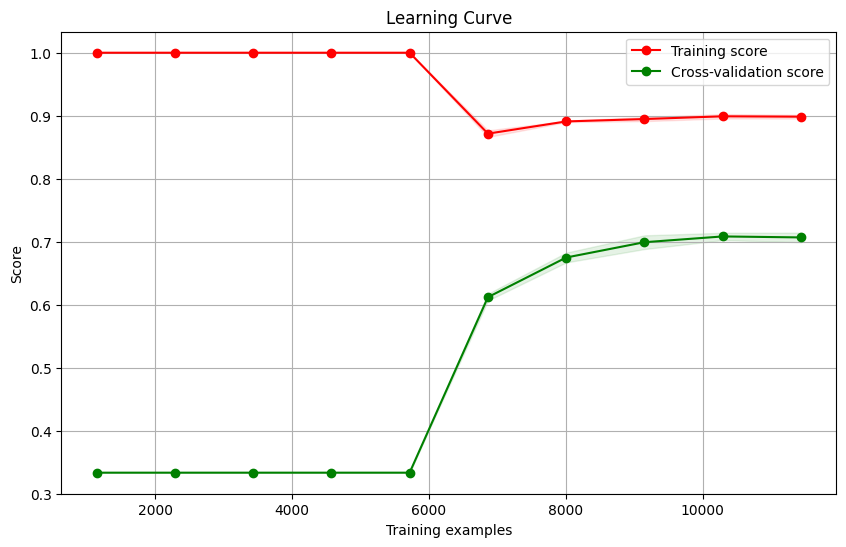

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_undersampled, y_train_undersampled, scoring, train_sizes)

In [22]:
## 4/7 stratified undersampling - data import
X_train_undersampled = pd.read_csv('X_train_undersampled_str.csv')

y_train_undersampled = pd.read_csv('y_train_undersampled_str.csv')

y_train_undersampled = np.ravel(y_train_undersampled.values)

In [23]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [24]:
dt_classifier = DecisionTreeClassifier(random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_undersampled, y_train_undersampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT strat undersampling:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_undersampled, y_train_undersampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)

#save model to a file
joblib.dump(best_dt_classifier, 'dt_stratified_undersampling_v2.pkl')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

['dt_stratified_undersampling_v2.pkl']

In [31]:
best_dt_classifier = joblib.load('dt_stratified_undersampling.pkl')
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [25]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4376


In [26]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8150


In [27]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[110974  47350]
 [   365   1311]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    158324
           1       0.03      0.78      0.05      1676

    accuracy                           0.70    160000
   macro avg       0.51      0.74      0.44    160000
weighted avg       0.99      0.70      0.81    160000



In [32]:
##conf for the strat undersampling previous
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[112989  45335]
 [   347   1329]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83    158324
           1       0.03      0.79      0.05      1676

    accuracy                           0.71    160000
   macro avg       0.51      0.75      0.44    160000
weighted avg       0.99      0.71      0.82    160000



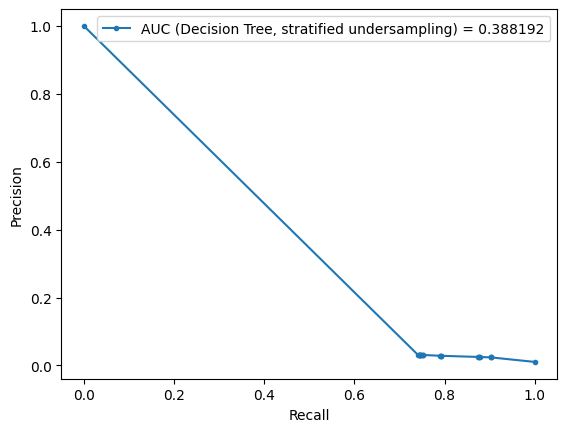

In [ ]:
###old model with random search!
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
#y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, stratified undersampling) = {auc_dt:.6f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

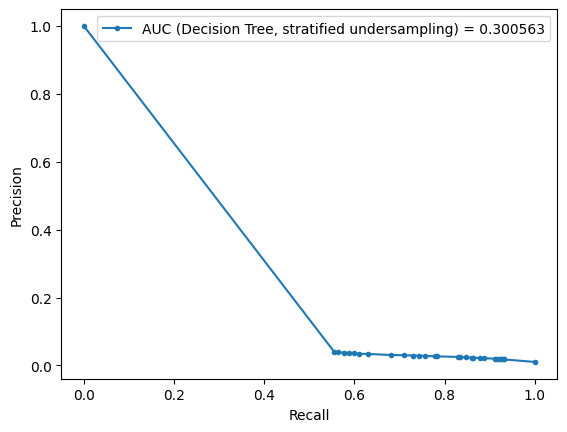

In [28]:
##NEW MODEL with full search

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
#y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, stratified undersampling) = {auc_dt:.6f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

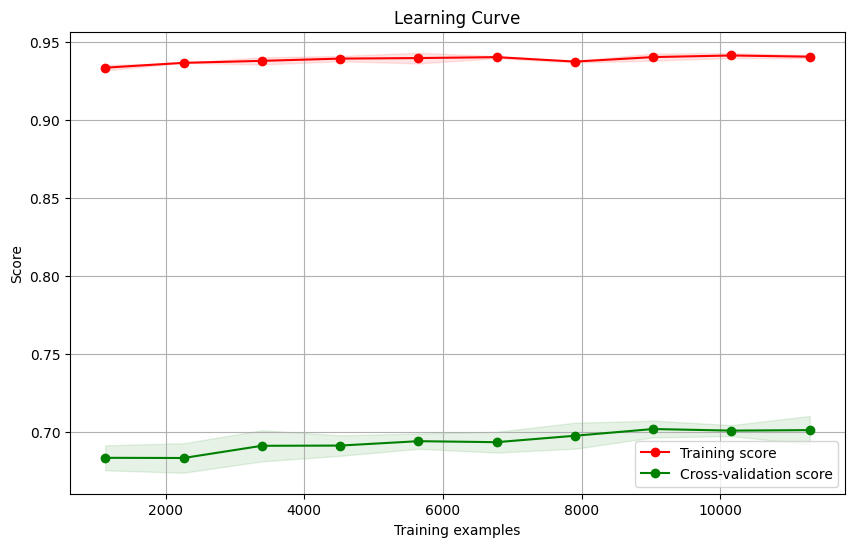

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10) ##not tuning max depth, stratified undersampling
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_undersampled, y_train_undersampled, scoring, train_sizes)

In [33]:
###stratified undersampling DT is overfitting -> prune the tree, manual adjustments
##train the dt classifier with relaxed hyperparameters
#Best Hyperparameters DT stratified undersampling: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}

#the best hyperparameters from the hyperparameter tuning
best_hyperparameters = {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}

##prune the tree further by setting max_depth to a smaller value
pruned_max_depth = 100
pruned_dt_classifier = DecisionTreeClassifier(max_depth=pruned_max_depth, **best_hyperparameters, random_state=42)
pruned_dt_classifier.fit(X_train_undersampled, y_train_undersampled)

# Evaluate the pruned classifier on the validation
y_pred_pruned = pruned_dt_classifier.predict(X_valid_transformed)


In [34]:
joblib.dump(pruned_dt_classifier, 'dt_stratified_undersampling_man_pruned.pkl')

['dt_stratified_undersampling_man_pruned.pkl']

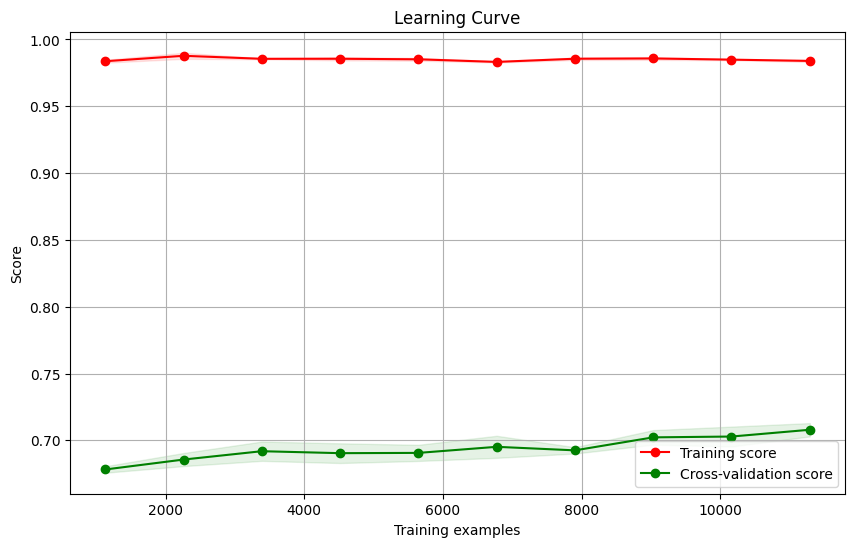

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(pruned_dt_classifier, X_train_undersampled, y_train_undersampled, scoring, train_sizes)

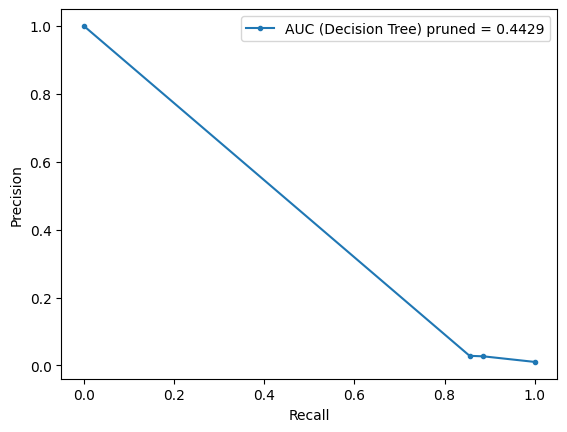

In [35]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = pruned_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree) pruned = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
f1 = f1_score(y_valid, y_pred_pruned, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4354


In [ ]:
f1 = f1_score(y_valid, y_pred_pruned, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8078


In [36]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_pruned))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred_pruned))

Confusion Matrix:
[[109239  49085]
 [   242   1434]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82    158324
           1       0.03      0.86      0.05      1676

    accuracy                           0.69    160000
   macro avg       0.51      0.77      0.44    160000
weighted avg       0.99      0.69      0.81    160000



In [ ]:
class_report = classification_report(y_valid, y_pred_pruned)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")

Class 0: F1 Score = 0.82
Class 1: F1 Score = 0.05
Class accuracy: F1 Score = 0.69
Class macro: F1 Score = 0.44
Class weighted: F1 Score = 0.81


In [37]:
##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = pruned_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred_pruned = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred_pruned)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)



Chosen threshold: 1.0
False Positive Rate: 0.3100288016977843
Recall: 0.7929594272076372
[[109239  49085]
 [   242   1434]]


In [38]:
best_dt_classifier = joblib.load('dt_stratified_undersampling_v2.pkl')
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [39]:
##custom scorer new model

##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred_pruned = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred_pruned)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Chosen threshold: 1.0
False Positive Rate: 0.1415515019832748
Recall: 0.7822195704057279
[[135913  22411]
 [   745    931]]


In [41]:
X_train_resampled = pd.read_csv('X_train_transformed_basicfull.csv')
#X_valid_transformed = pd.read_csv('X_valid_transformed_basicfull.csv')
#X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')

y_train_resampled = pd.read_csv('y_train_basicfull.csv')
#y_valid = pd.read_csv('y_valid_basicfull.csv')
#y_test = pd.read_csv('y_test_basicfull.csv')
y_train_resampled = np.ravel(y_train_resampled.values)
#y_valid = np.ravel(y_valid.values)
#y_test = np.ravel(y_test.values)

In [ ]:
###### class weights

In [42]:
##no sampling with class weight
#calc the weight for the positive class (#1)
#inv of the proportion of positive cases in the dataset
weight_positive = 1 / 0.011  # 1/0.011 = 90.91
 #set the class weights
class_weights = {0: 1, 1: weight_positive}
dt_classifier = DecisionTreeClassifier(class_weight=class_weights, random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT SMOTE:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_resampled, y_train_resampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)

#save model to a file
joblib.dump(best_dt_classifier, 'dt_classweights_v2.pkl')


Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   4.6s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   4.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   5.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   4.7s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   4.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   4.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   5.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

['dt_classweights_v2.pkl']

In [ ]:
best_dt_classifier = joblib.load('dt_basicn_classweights1.pkl')
y_pred = best_dt_classifier.predict(X_valid_transformed)

In [43]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5306


In [44]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9798


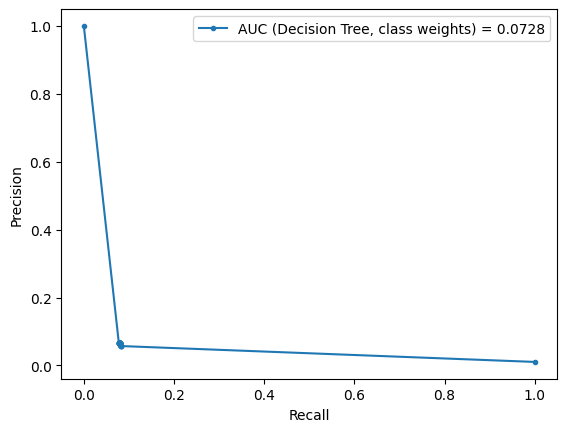

In [45]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Decision Tree, class weights) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [46]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")

Class 0: F1 Score = 0.99
Class 1: F1 Score = 0.07
Class accuracy: F1 Score = 0.98
Class macro: F1 Score = 0.53
Class weighted: F1 Score = 0.98


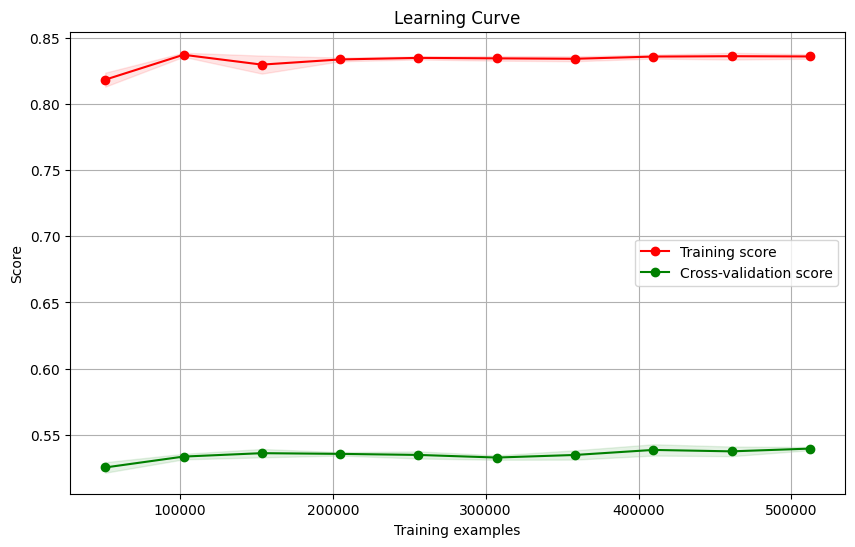

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_resampled, y_train_resampled, scoring, train_sizes)


In [48]:
##custom scorer

#obtain predicted probabilities for the positive class from the model
y_prob = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#apply the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)



Chosen threshold: 1.0
False Positive Rate: 0.011419620524999369
Recall: 0.07756563245823389
[[156516   1808]
 [  1546    130]]


In [49]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[156516   1808]
 [  1546    130]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158324
           1       0.07      0.08      0.07      1676

    accuracy                           0.98    160000
   macro avg       0.53      0.53      0.53    160000
weighted avg       0.98      0.98      0.98    160000



In [50]:
###best sampling for DT (stratified undersampling) + transactional data
X_train_resampled = pd.read_csv('X_train_undersampled_str_trans.csv')
X_valid_transformed = pd.read_csv('X_valid_transformed_basic_trans.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basic_trans.csv')

y_train_resampled = pd.read_csv('y_train_undersampled_str_trans.csv')
y_valid = pd.read_csv('y_valid_basic_trans.csv')
y_test = pd.read_csv('y_test_basic_trans.csv')
y_train_resampled = np.ravel(y_train_resampled.values)
y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)



In [51]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")


Number of features is the same in training and validation sets.


In [52]:
dt_classifier = DecisionTreeClassifier(random_state=42)

#parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], #auto is deprecated
    'max_depth': [None, 30, 50, 70, 100]
}

#GridSearchCV for full search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2
)

#fit the model using the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

#print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters DT str.undersampling on transactional:", best_params)

#train the DT with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train_resampled, y_train_resampled)

#evaluate the classifier on the test set
y_pred = best_dt_classifier.predict(X_valid_transformed)


#save model to a file
joblib.dump(best_dt_classifier, 'dt_stratified_undersampling_trans_v2.pkl')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split

['dt_stratified_undersampling_trans_v2.pkl']

In [53]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4434
F1 Score: 0.8255


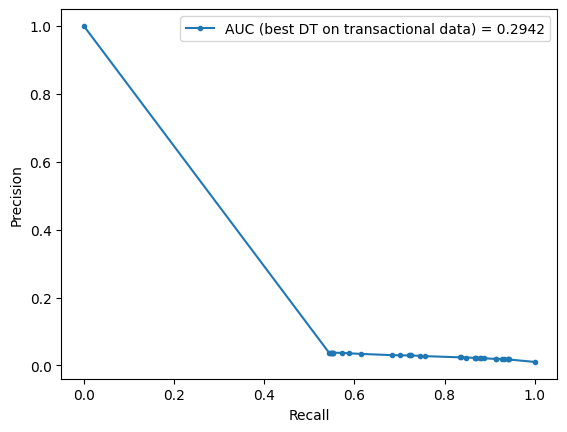

In [54]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = best_dt_classifier.predict_proba(X_valid_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (best DT on transactional data) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [55]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[113459  44865]
 [   408   1268]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83    158324
           1       0.03      0.76      0.05      1676

    accuracy                           0.72    160000
   macro avg       0.51      0.74      0.44    160000
weighted avg       0.99      0.72      0.83    160000



In [56]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")

Class 0: F1 Score = 0.83
Class 1: F1 Score = 0.05
Class accuracy: F1 Score = 0.72
Class macro: F1 Score = 0.44
Class weighted: F1 Score = 0.83


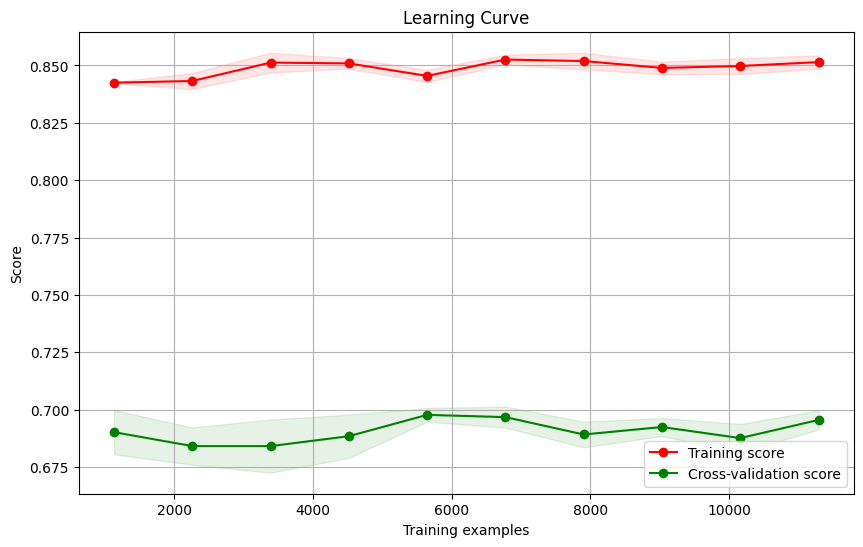

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(best_dt_classifier, X_train_resampled, y_train_resampled, scoring, train_sizes)

In [8]:
###generalization - str. undersampling decision tree on full data, test set
###out-of-sample generalization: best model making predictions on the test set
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')
y_test = np.ravel(y_test.values)
##load model
best_dt = joblib.load('dt_stratified_undersampling_man_pruned.pkl')
##y_pred

In [9]:
y_pred = best_dt.predict(X_test_transformed)

In [10]:
f1 = f1_score(y_test, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_test, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

F1 Score: 0.4354
F1 Score: 0.8062
Confusion Matrix:
[[136167  61627]
 [   363   1843]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81    197794
           1       0.03      0.84      0.06      2206

    accuracy                           0.69    200000
   macro avg       0.51      0.76      0.44    200000
weighted avg       0.99      0.69      0.81    200000



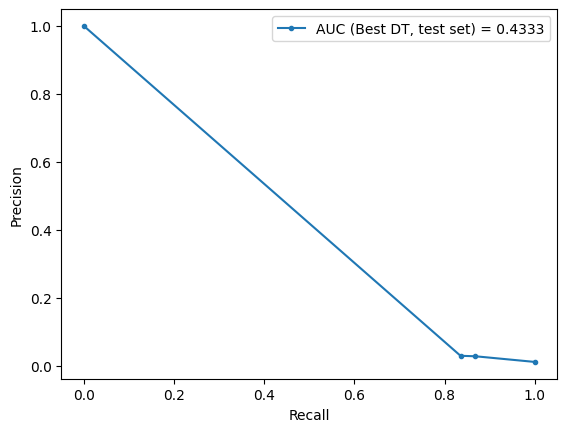

In [68]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
#y_valid =  y_valid
probabilities = best_dt.predict_proba(X_test_transformed)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_test, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Best DT, test set) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [15]:
y_pred = dt_class_weights.predict(X_valid_transformed)
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5306
F1 Score: 0.9798


In [4]:
### AUPRC for all

#load the saved models
dt_adasyn = joblib.load('dt_adasyn_v2.pkl')
dt_smote = joblib.load('dt_smote_v2.pkl')
dt_undersampl_random = joblib.load('dt_random_undersampling_v2.pkl')
dt_undersampl_strat = joblib.load('dt_stratified_undersampling_man_pruned.pkl')
dt_class_weights = joblib.load('dt_classweights_v2.pkl')

dt_trans = joblib.load('dt_stratified_undersampling_trans_v2.pkl')



In [3]:
dt_trans = joblib.load('dt_stratified_undersampling_trans_v2.pkl')

In [4]:
X_valid_transformed2 = pd.read_csv('X_valid_transformed_basic_trans.csv')

y_valid2 = pd.read_csv('y_valid_basic_trans.csv')

y_valid2 = np.ravel(y_valid2.values)

In [7]:
# Predictions
y_pred = dt_trans.predict(X_valid_transformed2)

# Confusion matrix and classification report

print("Confusion Matrix:")
print(confusion_matrix(y_valid2, y_pred))
print("\nClassification Report:")
print(classification_report(y_valid2, y_pred))

    # Custom scorer
y_prob = dt_trans.predict_proba(X_valid_transformed2)[:, 1]
sorted_probs = sorted(zip(y_prob, y_valid2), key=lambda x: x[0], reverse=True)
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp)
y_pred = (y_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y_valid2, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid2, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Confusion Matrix:
[[113459  44865]
 [   408   1268]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83    158324
           1       0.03      0.76      0.05      1676

    accuracy                           0.72    160000
   macro avg       0.51      0.74      0.44    160000
weighted avg       0.99      0.72      0.83    160000

Chosen threshold: 1.0
False Positive Rate: 0.14511381723554231
Recall: 0.5435560859188544
[[135349  22975]
 [   765    911]]


In [5]:
##data import

#import the data

X_valid_transformed = pd.read_csv('X_valid_transformed_basicfull.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')

y_valid = pd.read_csv('y_valid_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')

y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)


##transactional dataset import

X_valid_transformed2 = pd.read_csv('X_valid_transformed_basic_trans.csv')

y_valid2 = pd.read_csv('y_valid_basic_trans.csv')

y_valid2 = np.ravel(y_valid2.values)

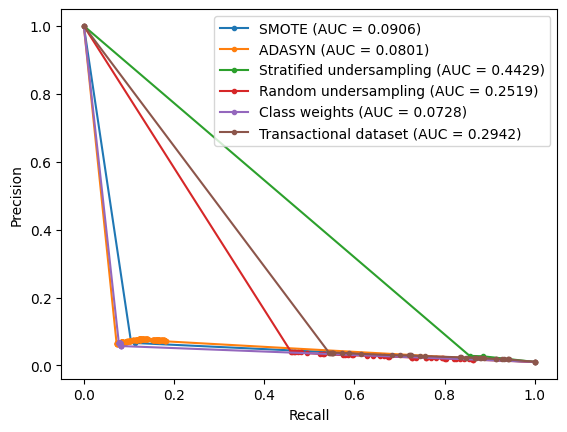

In [71]:
# List of models and their names
model_list = [dt_smote, dt_adasyn, dt_undersampl_strat, dt_undersampl_random, dt_class_weights, dt_trans]
model_names = ['SMOTE', 'ADASYN', 'Stratified undersampling', 'Random undersampling', 'Class weights', 'Transactional dataset']

# Plot each model on the same graph
for model, name in zip(model_list, model_names):
    # Choose the appropriate validation dataset based on the model
    if name in ['Transactional dataset']:
        X_valid_transformed = X_valid_transformed2
        y_valid = y_valid2
    else:
        X_valid_transformed = X_valid_transformed
        y_valid = y_valid

    # Calculate probabilities for the positive class
    probabilities = model.predict_proba(X_valid_transformed)[:, 1]

    # Calculate precision-recall pairs
    precision, recall, _ = precision_recall_curve(y_valid, probabilities)
    auc_score = auc(recall, precision)

    # Plot the precision-recall curve for the current model
    plt.plot(recall, precision, marker=".", label=f"{name} (AUC = {auc_score:.4f})")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

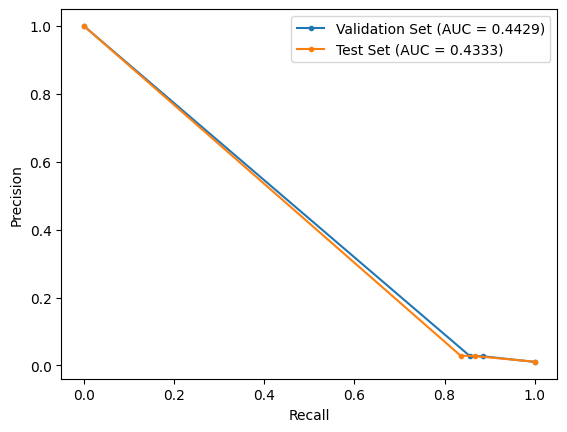

In [77]:
##best model - on validation and on test

# Assuming you have X_valid_transformed, y_valid, X_test_transformed, and y_test

# Choose the model for which you want to plot precision-recall curves
chosen_model = dt_undersampl_strat  # Replace with your chosen model

# Calculate probabilities for the positive class on the validation set
probabilities_valid = chosen_model.predict_proba(X_valid_transformed)[:, 1]

# Calculate precision-recall pairs for the validation set
precision_valid, recall_valid, _ = precision_recall_curve(y_valid, probabilities_valid)
auc_score_valid = auc(recall_valid, precision_valid)

# Calculate probabilities for the positive class on the test set
probabilities_test = chosen_model.predict_proba(X_test_transformed)[:, 1]

# Calculate precision-recall pairs for the test set
precision_test, recall_test, _ = precision_recall_curve(y_test, probabilities_test)
auc_score_test = auc(recall_test, precision_test)

# Plot the precision-recall curves for both validation and test sets
plt.plot(recall_valid, precision_valid, marker=".", label=f"Validation Set (AUC = {auc_score_valid:.4f})")
plt.plot(recall_test, precision_test, marker=".", label=f"Test Set (AUC = {auc_score_test:.4f})")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.model_selection import train_test_split
import joblib

# List of model filenames
model_filenames = [
    'dt_smote_v2.pkl',
    'dt_adasyn_v2.pkl',
    'dt_random_undersampling_v2.pkl',
    'dt_stratified_undersampling_man_pruned.pkl',
    'dt_classweights_v2.pkl',
]

# Loop to load and evaluate pre-saved Decision Tree models
for i, model_filename in enumerate(model_filenames, start=1):
    # Load the pre-saved Decision Tree model
    dt_classifier = joblib.load(model_filename)

    # Predictions
    y_pred = dt_classifier.predict(X_valid_transformed)

    # Confusion matrix and classification report
    print(f"\nModel {i}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred))

    # Custom scorer
    y_prob = dt_classifier.predict_proba(X_valid_transformed)[:, 1]
    sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)
    cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))
    target_cumulative_tp = int(0.9 * cumulative_tp[-1])
    threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp)
    y_pred = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)
    fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
    recall = recall_score(y_valid, y_pred)

    print(f"Chosen threshold: {threshold}")
    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(conf_matrix)



Model 1:
Confusion Matrix:
[[156057   2267]
 [  1501    175]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158324
           1       0.07      0.10      0.08      1676

    accuracy                           0.98    160000
   macro avg       0.53      0.55      0.54    160000
weighted avg       0.98      0.98      0.98    160000

Chosen threshold: 1.0
False Positive Rate: 0.014318738788812815
Recall: 0.10441527446300716
[[156057   2267]
 [  1501    175]]

Model 2:
Confusion Matrix:
[[155540   2784]
 [  1439    237]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    158324
           1       0.08      0.14      0.10      1676

    accuracy                           0.97    160000
   macro avg       0.53      0.56      0.54    160000
weighted avg       0.98      0.97      0.98    160000

Chosen threshold: 1.0
False Positive Rate: 0.

In [ ]:
# Predictions
y_pred = dt_trans.predict(X_valid_transformed2)

# Confusion matrix and classification report

print("Confusion Matrix:")
print(confusion_matrix(y_valid2, y_pred))
print("\nClassification Report:")
print(classification_report(y_valid2, y_pred))

    # Custom scorer
y_prob = dt_trans.predict_proba(X_valid_transformed2)[:, 1]
sorted_probs = sorted(zip(y_prob, y_valid2), key=lambda x: x[0], reverse=True)
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp)
y_pred = (y_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y_valid2, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid2, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

In [86]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
# Plot the decision tree
plt.figure(figsize=(300, 200))  # Adjust the figure size if needed
plot_tree(dt_undersampl_strat, filled=True, feature_names=X_valid_transformed.columns, class_names=np.unique(y_valid).astype(str), rounded=True, fontsize=8)
plt.show()


Output hidden; open in https://colab.research.google.com to view.